# <a id='toc1_'></a>[Efficiency Analysis](#toc0_)
This notebook demonstrates the use of `EfficiencyAnalysis` class in `src/analysis/efficiency_analysis.py` for analyzing the efficiency of jobs, users, and PI groups.

**Table of contents**<a id='toc0_'></a>    
- [Efficiency Analysis](#toc1_)    
  - [Setup](#toc1_1_)    
  - [All Metrics Partition 1](#toc1_2_)    
    - [Job Efficiency Metrics](#toc1_2_1_)    
      - [Find most inefficient jobs with no VRAM constraints based on `vram_hours`](#toc1_2_1_1_)    
    - [User Efficiency Metrics](#toc1_2_2_)    
      - [Find Inefficient Users based on `expected_value_alloc_vram_efficiency`](#toc1_2_2_1_)    
      - [Find Inefficient Users based on `vram_hours`](#toc1_2_2_2_)    
    - [PI Group Efficiency Metrics](#toc1_2_3_)    
      - [Find Inefficient PIs based on `vram_hours`](#toc1_2_3_1_)    
  - [Example: Analyze all jobs with no VRAM constraints](#toc1_3_)    
    - [Job Efficiency Metrics](#toc1_3_1_)    
      - [Problem with duplicate JobIDs](#toc1_3_1_1_)    
      - [Top users with most number of jobs that have no VRAM constraints](#toc1_3_1_2_)    
      - [Find inefficient jobs with no VRAM Constraints based on `alloc_vram_efficiency_score`](#toc1_3_1_3_)    

<!-- vscode-jupyter-toc-config
    numbering=false
    anchor=true
    flat=false
    minLevel=1
    maxLevel=6
    /vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [32]:
# Import required modules
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
project_root = str(Path.cwd().resolve().parent)
print(f"Project root: {project_root}")

Project root: C:\Users\Nitya Karthik A\ds4cg-job-analytics


In [34]:
# Add project root to sys.path for module imports
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.analysis import efficiency_analysis as ea
from src.visualization import JobsWithMetricsVisualizer, UsersWithMetricsVisualizer

# Automatically reload modules before executing code
# This is useful for development to see changes without restarting the kernel.
%load_ext autoreload
# Reload all modules imported with %aimport every time before executing the Python code typed.
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# Load the jobs DataFrame from DuckDB
query1 = "SELECT * FROM Jobs WHERE (map_contains(GPUType, 'a100')) AND (GPUs == 1);"
preprocessed_jobs_df = ea.load_preprocessed_jobs_dataframe_from_duckdb(
    db_path='../data/slurm_data.db',
    table_name='Jobs',
    query=query1
    )
display(preprocessed_jobs_df.head(10))
print(preprocessed_jobs_df.shape)


Connected to ../data/slurm_data.db
[Preprocessing] Running with new database format: GPU types as dictionary.
Fetched and saved partition_info.json from remote URL.
Disconnected from ../data/slurm_data.db


,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,user_jobs,account_jobs
0,38750282,<NA>,-1,bash,False,shell,pi_chuangg_umass_edu,jiabenchen_umass_edu,['a100'],normal,...,0.0,1.701478e+07,0.000080,0 days 00:11:57,80,<NA>,80,80,32,22546
1,38754198,<NA>,-1,sys/dashboard/sys/bc_jupyter,False,bc_jupyter,pi_mshao_umassd_edu,vbandi_umassd_edu,['x86_64'],normal,...,38.0,1.714425e+10,3.148984,0 days 00:00:19,<NA>,80,80,80,83,661
2,38755106,<NA>,-1,interactive,False,shell,pi_hzamani_umass_edu,mrafiee_umass_edu,['vram40'],normal,...,27.0,1.110556e+11,3.993254,0 days 00:00:26,40,80,80,80,45,4368
3,38755853,<NA>,-1,Template_Pendulum.sh,False,non-interactive,pi_gfelder_smith_edu,zji_smith_edu,['gpu:a100'],normal,...,0.0,2.815717e+09,48.104427,0 days 00:00:27,80,<NA>,80,80,54,54
4,38767669,<NA>,-1,bash,False,shell,pi_donghyunkim_umass_edu,soowangyang_umass_edu,['gpu:a100'],normal,...,0.0,1.412309e+09,0.089295,0 days 01:26:40,80,<NA>,80,80,7,126
5,38772272,<NA>,-1,sys/dashboard/sys/bc_vscode,False,bc_vscode,pi_mendres_umass_edu,ppenta_umass_edu,"['vram80', 'gpu:a100']",normal,...,0.0,2.073360e+10,0.742180,0 days 00:00:19,80,<NA>,80,80,40,40
6,38777804,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,77.0,3.440394e+08,98.004761,0 days 00:00:28,80,<NA>,80,80,43770,43770
7,38777806,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,0.0,3.466895e+08,99.955582,0 days 00:00:09,80,<NA>,80,80,43770,43770
8,38778439,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,74.0,3.487375e+08,99.940666,0 days 00:00:23,80,<NA>,80,40,43770,43770
9,38779093,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,75.0,3.485778e+08,99.922623,0 days 00:00:28,80,<NA>,80,40,43770,43770


(217499, 33)


## <a id='toc1_1_'></a>[Setup](#toc0_)

In [36]:
efficiency_analysis = ea.EfficiencyAnalysis(
	jobs_df=preprocessed_jobs_df
)


## <a id='toc1_1_'></a>[All Metrics Partition 1](#toc1_2_)

In [37]:
zero_gpu_mem_usage_jobs = efficiency_analysis.filter_jobs_for_analysis(
    gpu_mem_usage_filter=0)
zero_gpu_mem_usage_jobs

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,user_jobs,account_jobs
0,38750282,<NA>,-1,bash,False,shell,pi_chuangg_umass_edu,jiabenchen_umass_edu,['a100'],normal,...,0.0,1.701478e+07,0.000080,0 days 00:11:57,80,<NA>,80,80,32,22546
3,38755853,<NA>,-1,Template_Pendulum.sh,False,non-interactive,pi_gfelder_smith_edu,zji_smith_edu,['gpu:a100'],normal,...,0.0,2.815717e+09,48.104427,0 days 00:00:27,80,<NA>,80,80,54,54
4,38767669,<NA>,-1,bash,False,shell,pi_donghyunkim_umass_edu,soowangyang_umass_edu,['gpu:a100'],normal,...,0.0,1.412309e+09,0.089295,0 days 01:26:40,80,<NA>,80,80,7,126
5,38772272,<NA>,-1,sys/dashboard/sys/bc_vscode,False,bc_vscode,pi_mendres_umass_edu,ppenta_umass_edu,"['vram80', 'gpu:a100']",normal,...,0.0,2.073360e+10,0.742180,0 days 00:00:19,80,<NA>,80,80,40,40
7,38777806,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,0.0,3.466895e+08,99.955582,0 days 00:00:09,80,<NA>,80,80,43770,43770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273792,40130437,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,0.0,2.217165e+08,99.969376,0 days 03:29:09,80,<NA>,80,80,43770,43770
273823,40130638,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,0.0,2.866954e+08,99.956154,0 days 03:20:44,80,<NA>,80,80,43770,43770
273847,40130893,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,0.0,2.526536e+08,99.947624,0 days 02:55:07,80,<NA>,80,80,43770,43770
273848,40130924,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,0.0,2.853028e+08,99.942238,0 days 02:50:06,80,<NA>,80,80,43770,43770


In [39]:
metrics_dict_p1 = efficiency_analysis.calculate_all_efficiency_metrics(zero_gpu_mem_usage_jobs)

jobs_with_metrics_p1 = metrics_dict_p1["jobs_with_efficiency_metrics"]
users_with_metrics_p1 = metrics_dict_p1["users_with_efficiency_metrics"]
pi_accounts_with_metrics_p1 = metrics_dict_p1["pi_accounts_with_efficiency_metrics"]
     


## <a id='toc1_1_'></a>[All Metrics Partition 2](#toc1_2_)

In [40]:
gpu_used_jobs = efficiency_analysis.filter_jobs_for_analysis(
    gpu_mem_usage_filter={"min": 0, "inclusive": False}
)
gpu_used_jobs


,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,user_jobs,account_jobs
1,38754198,<NA>,-1,sys/dashboard/sys/bc_jupyter,False,bc_jupyter,pi_mshao_umassd_edu,vbandi_umassd_edu,['x86_64'],normal,...,38.0,1.714425e+10,3.148984,0 days 00:00:19,<NA>,80,80,80,83,661
2,38755106,<NA>,-1,interactive,False,shell,pi_hzamani_umass_edu,mrafiee_umass_edu,['vram40'],normal,...,27.0,1.110556e+11,3.993254,0 days 00:00:26,40,80,80,80,45,4368
6,38777804,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,77.0,3.440394e+08,98.004761,0 days 00:00:28,80,<NA>,80,80,43770,43770
8,38778439,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,74.0,3.487375e+08,99.940666,0 days 00:00:23,80,<NA>,80,40,43770,43770
9,38779093,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,75.0,3.485778e+08,99.922623,0 days 00:00:28,80,<NA>,80,40,43770,43770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273851,40130945,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,73.0,2.898862e+08,99.918419,0 days 02:55:35,80,<NA>,80,40,43770,43770
273852,40130961,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,70.0,2.741903e+08,99.904396,0 days 02:53:54,80,<NA>,80,80,43770,43770
273853,40130966,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,74.0,2.487665e+08,99.791695,0 days 02:59:10,80,<NA>,80,80,43770,43770
273855,40130998,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,72.0,2.472550e+08,99.813065,0 days 03:11:45,80,<NA>,80,80,43770,43770


In [41]:
metrics_dict_p2 = efficiency_analysis.calculate_all_efficiency_metrics(zero_gpu_mem_usage_jobs)

jobs_with_metrics_p2 = metrics_dict_p1["jobs_with_efficiency_metrics"]
users_with_metrics_p2 = metrics_dict_p1["users_with_efficiency_metrics"]
pi_accounts_with_metrics_p2 = metrics_dict_p1["pi_accounts_with_efficiency_metrics"]


## <a id='toc1_1_'></a>[Metrics for all A100 Users](#toc1_2_)

In [44]:
all_a100_jobs = efficiency_analysis.filter_jobs_for_analysis(
    
)
all_a100_jobs

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,user_jobs,account_jobs
0,38750282,<NA>,-1,bash,False,shell,pi_chuangg_umass_edu,jiabenchen_umass_edu,['a100'],normal,...,0.0,1.701478e+07,0.000080,0 days 00:11:57,80,<NA>,80,80,32,22546
1,38754198,<NA>,-1,sys/dashboard/sys/bc_jupyter,False,bc_jupyter,pi_mshao_umassd_edu,vbandi_umassd_edu,['x86_64'],normal,...,38.0,1.714425e+10,3.148984,0 days 00:00:19,<NA>,80,80,80,83,661
2,38755106,<NA>,-1,interactive,False,shell,pi_hzamani_umass_edu,mrafiee_umass_edu,['vram40'],normal,...,27.0,1.110556e+11,3.993254,0 days 00:00:26,40,80,80,80,45,4368
3,38755853,<NA>,-1,Template_Pendulum.sh,False,non-interactive,pi_gfelder_smith_edu,zji_smith_edu,['gpu:a100'],normal,...,0.0,2.815717e+09,48.104427,0 days 00:00:27,80,<NA>,80,80,54,54
4,38767669,<NA>,-1,bash,False,shell,pi_donghyunkim_umass_edu,soowangyang_umass_edu,['gpu:a100'],normal,...,0.0,1.412309e+09,0.089295,0 days 01:26:40,80,<NA>,80,80,7,126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273852,40130961,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,70.0,2.741903e+08,99.904396,0 days 02:53:54,80,<NA>,80,80,43770,43770
273853,40130966,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,74.0,2.487665e+08,99.791695,0 days 02:59:10,80,<NA>,80,80,43770,43770
273855,40130998,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,72.0,2.472550e+08,99.813065,0 days 03:11:45,80,<NA>,80,80,43770,43770
273856,40131017,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,70.0,2.090107e+08,99.810341,0 days 03:11:23,80,<NA>,80,80,43770,43770


In [45]:
metrics_dict = efficiency_analysis.calculate_all_efficiency_metrics(filtered_jobs)

jobs_with_metrics = metrics_dict["jobs_with_efficiency_metrics"]
users_with_metrics = metrics_dict["users_with_efficiency_metrics"]
pi_accounts_with_metrics = metrics_dict["pi_accounts_with_efficiency_metrics"]

In [46]:
# Set option to display all columns
pd.set_option("display.max_columns", None)
# Display the DataFrame
display(jobs_with_metrics.head(10))
# To revert to default settings (optional)
pd.reset_option("display.max_columns")

print(f"Jobs found: {len(jobs_with_metrics)}")

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,ExitCode,SubmitTime,StartTime,Elapsed,TimeLimit,Partition,NodeList,CPUs,gpu_count,GPUType,GPUMemUsage,GPUComputeUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,user_jobs,account_jobs,job_hours,vram_hours,used_vram_gib,alloc_vram_efficiency,vram_constraint_efficiency,alloc_vram_efficiency_score,vram_constraint_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency
0,38750282,<NA>,-1,bash,False,shell,pi_chuangg_umass_edu,jiabenchen_umass_edu,['a100'],normal,TIMEOUT,SUCCESS,2025-06-26 16:37:02,2025-06-26 16:48:59,0 days 08:00:11,0 days 08:00:00,gpu,[gpu022],16,1,{'a100': 1},0.0,0.0,0.000080,0 days 00:11:57,80,<NA>,80,80,32,22546,8.003056,640.244444,0.0,0.0,0.0,-inf,-inf,0.015846,40.000,0.000396
3,38755853,<NA>,-1,Template_Pendulum.sh,False,non-interactive,pi_gfelder_smith_edu,zji_smith_edu,['gpu:a100'],normal,COMPLETED,SUCCESS,2025-06-26 18:32:51,2025-06-26 18:33:18,0 days 07:24:47,2 days 00:00:00,gpu-preempt,[uri-gpu003],32,1,{'a100': 1},0.0,0.0,48.104427,0 days 00:00:27,80,<NA>,80,80,54,54,7.413056,593.044444,0.0,0.0,0.0,-inf,-inf,2.622341,78.125,0.033566
4,38767669,<NA>,-1,bash,False,shell,pi_donghyunkim_umass_edu,soowangyang_umass_edu,['gpu:a100'],normal,TIMEOUT,SUCCESS,2025-06-26 20:58:58,2025-06-26 22:25:38,0 days 02:00:02,0 days 02:00:00,gpu,[gpu022],8,1,{'a100': 1},0.0,0.0,0.089295,0 days 01:26:40,80,<NA>,80,80,7,126,2.000556,160.044444,0.0,0.0,0.0,-inf,-inf,1.315315,120.000,0.010961
5,38772272,<NA>,-1,sys/dashboard/sys/bc_vscode,False,bc_vscode,pi_mendres_umass_edu,ppenta_umass_edu,"['vram80', 'gpu:a100']",normal,TIMEOUT,SUCCESS,2025-06-26 21:52:38,2025-06-26 21:52:57,0 days 04:00:14,0 days 04:00:00,gpu-preempt,[uri-gpu007],8,1,{'a100': 1},0.0,0.0,0.742180,0 days 00:00:19,80,<NA>,80,80,40,40,4.003889,320.311111,0.0,0.0,0.0,-inf,-inf,19.309669,32.000,0.603427
7,38777806,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,COMPLETED,SUCCESS,2025-06-26 22:18:22,2025-06-26 22:18:31,0 days 01:42:33,0 days 02:00:00,gpu-preempt,[umd-cscdr-gpu001],1,1,{'a100': 1},0.0,0.0,99.955582,0 days 00:00:09,80,<NA>,80,80,43770,43770,1.709167,136.733333,0.0,0.0,0.0,-inf,-inf,0.322880,8.000,0.040360
11,38779240,<NA>,-1,sys/dashboard/sys/bc_vscode,False,bc_vscode,pi_hongyu_umass_edu,sahgupta_umass_edu,"['vram80', 'gpu:a100']",normal,TIMEOUT,SUCCESS,2025-06-26 23:20:07,2025-06-26 23:20:23,0 days 01:00:17,0 days 01:00:00,gpu-preempt,[umd-cscdr-gpu001],8,1,{'a100': 1},0.0,0.0,2.393937,0 days 00:00:16,80,<NA>,80,80,10,4554,1.004722,80.377778,0.0,0.0,0.0,-inf,-inf,21.635174,32.000,0.676099
13,38779517,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,COMPLETED,SUCCESS,2025-06-26 23:34:15,2025-06-26 23:34:33,0 days 01:43:02,0 days 02:00:00,gpu-preempt,[uri-gpu003],1,1,{'a100': 1},0.0,0.0,99.930107,0 days 00:00:18,80,<NA>,80,80,43770,43770,1.717222,137.377778,0.0,0.0,0.0,-inf,-inf,0.321415,8.000,0.040177
19,38780174,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,COMPLETED,SUCCESS,2025-06-26 23:58:12,2025-06-26 23:58:25,0 days 01:42:20,0 days 02:00:00,gpu-preempt,[uri-gpu003],1,1,{'a100': 1},0.0,0.0,99.902885,0 days 00:00:13,80,<NA>,80,80,43770,43770,1.705556,136.444444,0.0,0.0,0.0,-inf,-inf,0.323009,8.000,0.040376
20,38780196,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,COMPLETED,SUCCESS,2025-06-27 00:00:29,2025-06-27 00:00:58,0 days 01:42:56,0 days 02:00:00,gpu-preempt,[uri-gpu003],1,1,{'a100': 1},0.0,0.0,99.929611,0 days 00:00:29,80,<NA>,80,80,43770,43770,1.715556,137.244444,0.0,0.0,0.0,-inf,-inf,0.327255,8.000,0.040907
21,38780201,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,COMPLETED,SUCCESS,2025-06-27 00:01:03,2025-06-27 00:

Jobs found: 16147



Top inefficient Jobs by VRAM-hours:


,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,job_hours,vram_hours,used_vram_gib,alloc_vram_efficiency,vram_constraint_efficiency,alloc_vram_efficiency_score,vram_constraint_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency
138328,26597450,<NA>,-1,sbatch,False,non-interactive,pi_atreya_chakraborty_umb_edu,poojan_patel001_umb_edu,['a100'],long,...,324.005000,25920.400000,0.0,0.0,0.0,-inf,-inf,1.907730,50.0,0.038155
171403,26303667,<NA>,-1,sbatch,False,non-interactive,pi_atreya_chakraborty_umb_edu,poojan_patel001_umb_edu,['a100'],long,...,207.378611,16590.288889,0.0,0.0,0.0,-inf,-inf,0.000000,50.0,0.000000
171404,26302632,<NA>,-1,sbatch,False,non-interactive,pi_atreya_chakraborty_umb_edu,poojan_patel001_umb_edu,['a100'],long,...,203.018056,16241.444444,0.0,0.0,0.0,-inf,-inf,0.000000,50.0,0.000000
203147,25722713,<NA>,-1,Au2Tre18_tddft_3.sh,False,non-interactive,pi_jerome_delhommelle_uml_edu,kithmasajinidileka_gampalaliyanapathiranage_st...,[],long,...,195.543611,15643.488889,0.0,0.0,<NA>,-inf,<NA>,479.994141,480.0,0.999988
187650,26015347,<NA>,-1,Au2Tre18_tddft_4.sh,False,non-interactive,pi_jerome_delhommelle_uml_edu,kithmasajinidileka_gampalaliyanapathiranage_st...,[],long,...,182.120000,14569.600000,0.0,0.0,<NA>,-inf,<NA>,479.991058,480.0,0.999981
160442,26597450,<NA>,-1,sbatch,False,non-interactive,pi_atreya_chakraborty_umb_edu,poojan_patel001_umb_edu,['a100'],long,...,162.681389,13014.511111,0.0,0.0,0.0,-inf,-inf,1.759747,50.0,0.035195
152187,26597450,<NA>,-1,sbatch,False,non-interactive,pi_atreya_chakraborty_umb_edu,poojan_patel001_umb_edu,['a100'],long,...,160.326389,12826.111111,0.0,0.0,0.0,-inf,-inf,1.798832,50.0,0.035977
75440,32971404,<NA>,-1,3as,False,non-interactive,pi_rrahimi_umass_edu,ngultran_umass_edu,['vram80'],normal,...,112.200278,8976.022222,0.0,0.0,0.0,-inf,-inf,0.000000,200.0,0.000000
165319,26597450,<NA>,-1,sbatch,False,non-interactive,pi_atreya_chakraborty_umb_edu,poojan_patel001_umb_edu,['a100'],long,...,111.948056,8955.844444,0.0,0.0,0.0,-inf,-inf,1.750156,50.0,0.035003
15531,35533646,<NA>,-1,regression,False,non-interactive,pi_pengbai_umass_edu,yachanliu_umass_edu,['a100'],long,...,103.778333,8302.266667,0.0,0.0,0.0,-inf,-inf,19.983921,20.0,0.999196


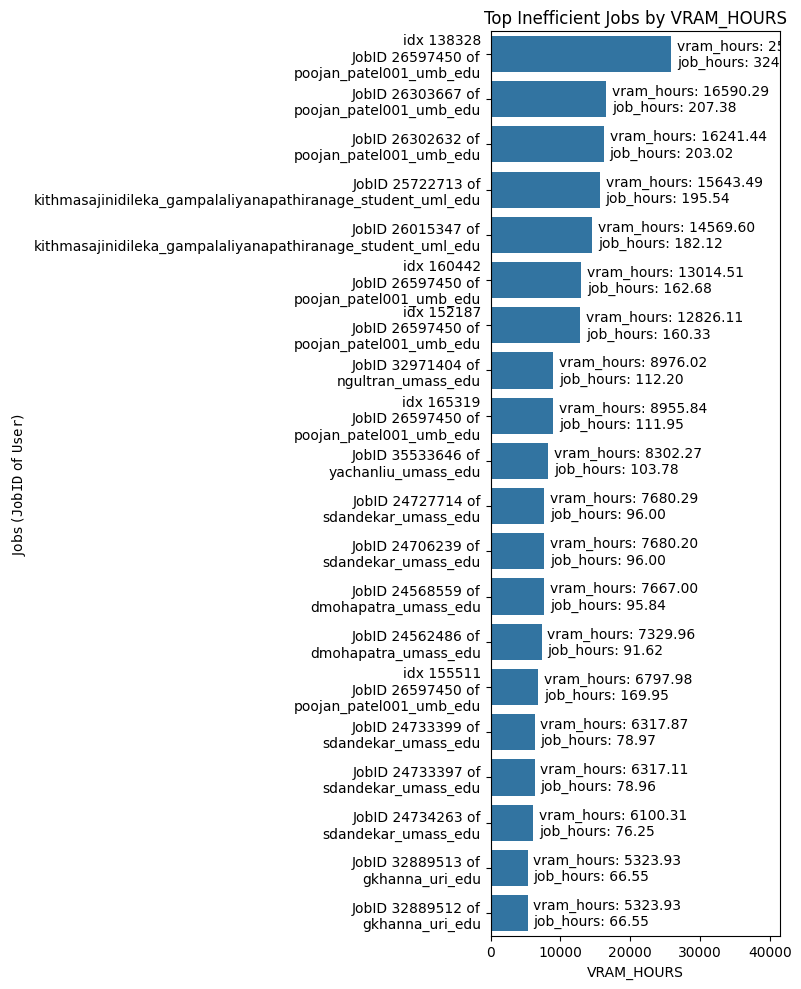

In [47]:
inefficient_jobs_vram_hours = efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=ea.MetricsDataFrameNameEnum.JOBS,
    sorting_key="vram_hours",
    ascending=False,  # Sort by vram_hours in descending order
    filter_criteria={
        "vram_hours": {"min": 80 * 24, "inclusive": True},  # VRAM-hours threshold for identifying inefficient jobs
    },
)
# Display top inefficient users by VRAM-hours
print("\nTop inefficient Jobs by VRAM-hours:")
display(inefficient_jobs_vram_hours.head(10))

# Plot top inefficient jobs by VRAM-hours, with VRAM-hours as labels
jobs_with_metrics_visualizer = JobsWithMetricsVisualizer(inefficient_jobs_vram_hours.head(20))
jobs_with_metrics_visualizer.visualize(
    column="vram_hours",
    bar_label_columns=["vram_hours", "job_hours"],
)

In [49]:
users_with_metrics

,User,job_count,user_job_hours,pi_account,avg_alloc_vram_efficiency_score,avg_vram_constraint_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_vram_constraint_efficiency,expected_value_gpu_count,vram_hours
0,aabedeen_umass_edu,3,8.896667,pi_wenlongzhao_umass_edu,<NA>,<NA>,0.0,0.0,1.0,711.733333
1,aafzali_umass_edu,44,301.710833,pi_aghasemi_umass_edu,<NA>,<NA>,0.0,0.0,1.0,24136.866667
2,aagrawal_umass_edu,2,2.287500,pi_jdomke_umass_edu,<NA>,<NA>,0.0,0.0,1.0,183.000000
3,aamballa_umass_edu,1,4.006944,pi_hongyu_umass_edu,<NA>,<NA>,0.0,0.0,1.0,320.555556
4,aaronsun_umass_edu,5,202.363889,pi_gvanhorn_umass_edu,<NA>,<NA>,0.0,<NA>,1.0,16189.111111
...,...,...,...,...,...,...,...,...,...,...
387,zhipengtang_umass_edu,2,2.004444,pi_elearned_umass_edu,<NA>,<NA>,0.0,0.0,1.0,160.355556
388,zhoulin-qc-group_umass_edu,9,43.438889,pi_zhoulin_umass_edu,<NA>,<NA>,0.0,0.0,1.0,3475.111111
389,zibinchen_umass_edu,1,0.791389,pi_lgao_umass_edu,<NA>,<NA>,0.0,0.0,1.0,63.311111
390,zji_smith_edu,15,81.941111,pi_gfelder_smith_edu,<NA>,<NA>,0.0,0.0,1.0,6555.288889



Top inefficient users by allocated vram efficiency:


,User,job_count,user_job_hours,pi_account,avg_alloc_vram_efficiency_score,avg_vram_constraint_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_vram_constraint_efficiency,expected_value_gpu_count,vram_hours
1,aafzali_umass_edu,44,301.710833,pi_aghasemi_umass_edu,<NA>,<NA>,0.0,0.0,1.0,24136.866667
4,aaronsun_umass_edu,5,202.363889,pi_gvanhorn_umass_edu,<NA>,<NA>,0.0,<NA>,1.0,16189.111111
5,aatmakuru_umass_edu,5,15.758056,pi_hzamani_umass_edu,<NA>,<NA>,0.0,0.0,1.0,1260.644444
10,abhinavs_umass_edu,9,49.043056,pi_chuangg_umass_edu,<NA>,<NA>,0.0,0.0,1.0,3923.444444
11,absahoo_umass_edu,46,209.206111,pi_mccallum_umass_edu,<NA>,<NA>,0.0,0.0,1.0,16043.366667
13,achaloo_umass_edu,44,187.434722,pi_wenlongzhao_umass_edu,<NA>,<NA>,0.0,0.0,1.0,14994.777778
14,achyut_subedi_uri_edu,5,13.735000,pi_ashgiri_uri_edu,<NA>,<NA>,0.0,<NA>,1.0,1098.800000
15,aeyanashraf_umass_edu,7,21.149167,pi_wenlongzhao_umass_edu,<NA>,<NA>,0.0,0.0,1.0,1691.933333
17,aghasemi_umass_edu,33,144.898333,pi_aghasemi_umass_edu,<NA>,<NA>,0.0,0.0,1.0,11591.866667
19,aheryudono_umassd_edu,5,2.631944,pi_aheryudono_umassd_edu,<NA>,<NA>,0.0,0.0,1.0,210.555556


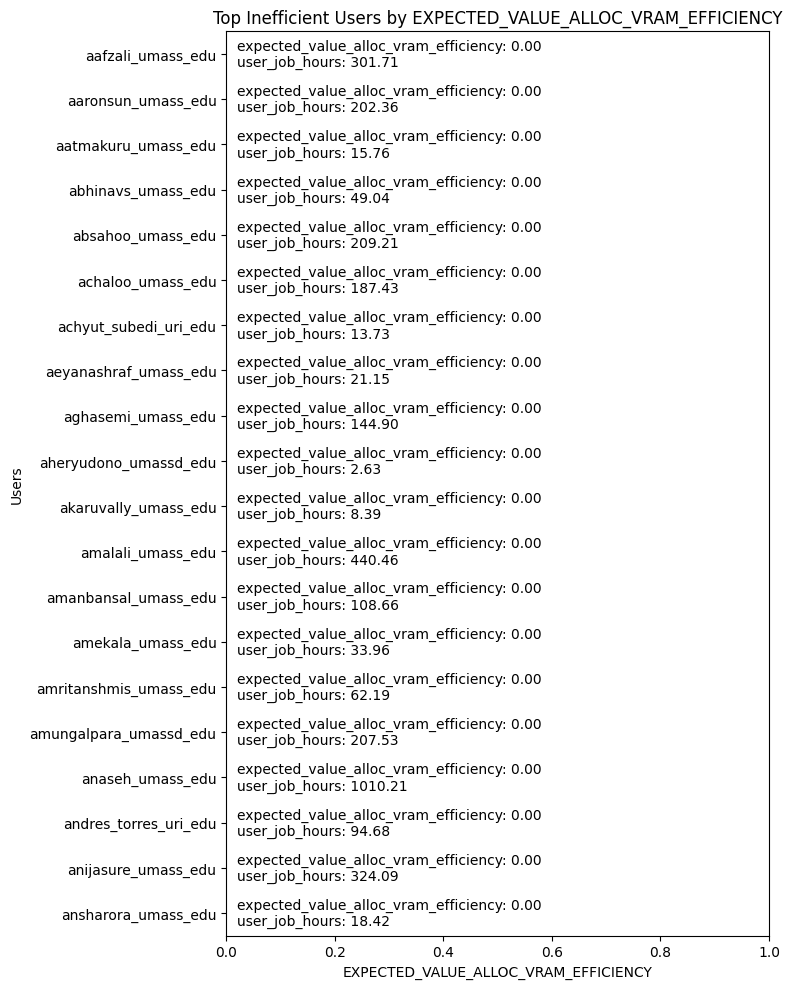

In [50]:
inefficient_users_alloc_vram_eff = efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=ea.MetricsDataFrameNameEnum.USERS,
    sorting_key="expected_value_alloc_vram_efficiency",
    ascending=True,  # we want to find users with low efficiency
    filter_criteria={
        "expected_value_alloc_vram_efficiency": {"max": 0.3, "inclusive": True},
        "job_count": {"min": 5, "inclusive": True},  # Minimum number of jobs to consider a user
    },
)
print("\nTop inefficient users by allocated vram efficiency:")
display(inefficient_users_alloc_vram_eff.head(20))

# Plot top inefficient users by allocated vram efficiency, with allocated vram efficiency as labels
users_with_metrics_visualizer = UsersWithMetricsVisualizer(inefficient_users_alloc_vram_eff.head(20))
users_with_metrics_visualizer.visualize(
    column="expected_value_alloc_vram_efficiency",
    bar_label_columns=["expected_value_alloc_vram_efficiency", "user_job_hours"],
    figsize=(8, 10),
)


Top inefficient users by allocated vram efficiency:


,User,job_count,user_job_hours,pi_account,avg_alloc_vram_efficiency_score,avg_vram_constraint_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_vram_constraint_efficiency,expected_value_gpu_count,vram_hours
1,aafzali_umass_edu,44,301.710833,pi_aghasemi_umass_edu,<NA>,<NA>,0.0,0.0,1.0,24136.866667
4,aaronsun_umass_edu,5,202.363889,pi_gvanhorn_umass_edu,<NA>,<NA>,0.0,<NA>,1.0,16189.111111
5,aatmakuru_umass_edu,5,15.758056,pi_hzamani_umass_edu,<NA>,<NA>,0.0,0.0,1.0,1260.644444
10,abhinavs_umass_edu,9,49.043056,pi_chuangg_umass_edu,<NA>,<NA>,0.0,0.0,1.0,3923.444444
11,absahoo_umass_edu,46,209.206111,pi_mccallum_umass_edu,<NA>,<NA>,0.0,0.0,1.0,16043.366667
13,achaloo_umass_edu,44,187.434722,pi_wenlongzhao_umass_edu,<NA>,<NA>,0.0,0.0,1.0,14994.777778
14,achyut_subedi_uri_edu,5,13.735000,pi_ashgiri_uri_edu,<NA>,<NA>,0.0,<NA>,1.0,1098.800000
15,aeyanashraf_umass_edu,7,21.149167,pi_wenlongzhao_umass_edu,<NA>,<NA>,0.0,0.0,1.0,1691.933333
17,aghasemi_umass_edu,33,144.898333,pi_aghasemi_umass_edu,<NA>,<NA>,0.0,0.0,1.0,11591.866667
19,aheryudono_umassd_edu,5,2.631944,pi_aheryudono_umassd_edu,<NA>,<NA>,0.0,0.0,1.0,210.555556


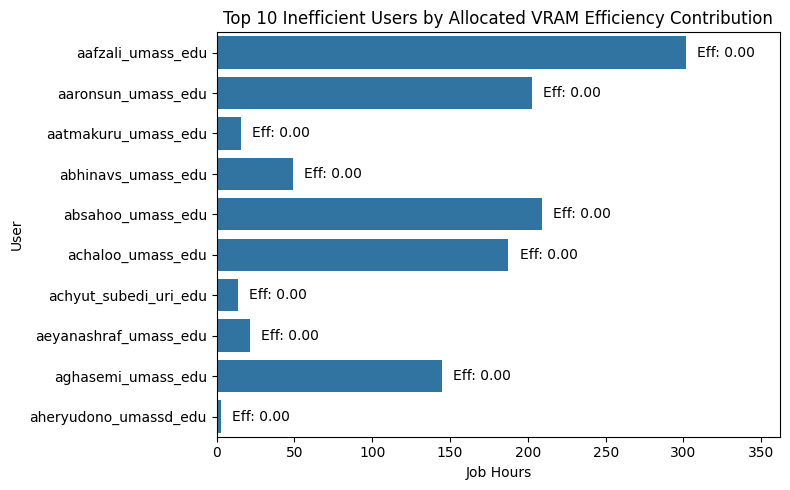

In [51]:
inefficient_users = efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=ea.MetricsDataFrameNameEnum.USERS,
    sorting_key="expected_value_alloc_vram_efficiency",
    ascending=True,  # we want to find users with low efficiency
    filter_criteria={
        "expected_value_alloc_vram_efficiency": {"max": 0.3, "inclusive": True},
        "job_count": {"min": 5, "inclusive": True},  # Minimum number of jobs to consider a user
    },
)

# Display top inefficient users by job count
print("\nTop inefficient users by allocated vram efficiency:")
display(inefficient_users.head(10))


# Plot top inefficient users by GPU hours, with efficiency as labels
top_users = inefficient_users.head(10)

plt.figure(figsize=(8, 5))
barplot = sns.barplot(y=top_users["User"], x=top_users["user_job_hours"], orient="h")
plt.xlabel("Job Hours")
plt.ylabel("User")
plt.title("Top 10 Inefficient Users by Allocated VRAM Efficiency Contribution")

# Annotate bars with expected_value_alloc_vram_efficiency, keeping text fully inside the plot's right spine
ax = barplot
xmax = top_users["user_job_hours"].max()
# Add headroom for annotation space (20% extra)
xlim = xmax * 1.20 if xmax > 0 else 1
ax.set_xlim(0, xlim)

# Calculate annotation x-position: place at 98% of xlim or just left of the right spine, whichever is smaller
for i, (job_hours, efficiency) in enumerate(
    zip(
        top_users["user_job_hours"],
        top_users["expected_value_alloc_vram_efficiency"],
        strict=True,
    )
):
    # Place annotation at min(job_hours + 2% of xlim, 98% of xlim)
    xpos = min(job_hours + xlim * 0.02, xlim * 0.98)
    # If bar is very close to right spine, nudge annotation left to avoid overlap
    if xpos > xlim * 0.96:
        xpos = xlim * 0.96
    ax.text(xpos, i, f"Eff: {efficiency:.2f}", va="center", ha="left", fontsize=10, color="black", clip_on=True)

plt.tight_layout()
plt.show()


Top inefficient users by VRAM-hours:


,User,job_count,user_job_hours,pi_account,avg_alloc_vram_efficiency_score,avg_vram_constraint_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_vram_constraint_efficiency,expected_value_gpu_count,vram_hours
94,dmohapatra_umass_edu,2154,6780.990833,pi_dmohapatra_umass_edu,<NA>,<NA>,0.0,<NA>,1.0,542363.522222
276,rvmathew_umass_edu,3239,3441.875556,pi_grason_umass_edu,<NA>,<NA>,0.0,0.0,1.0,273920.266667
33,anthony_bowers_student_uml_edu,438,3156.654722,pi_subash_sharma_uml_edu,<NA>,<NA>,0.0,<NA>,1.0,250611.100000
247,poojan_patel001_umb_edu,40,1794.747500,pi_atreya_chakraborty_umb_edu,<NA>,<NA>,0.0,0.0,1.0,132621.366667
158,jroh_umass_edu,323,1626.358889,pi_ahoumansadr_umass_edu,<NA>,<NA>,0.0,0.0,1.0,129655.788889
167,kaichunliu_umass_edu,308,1619.943333,pi_sunghoonlee_umass_edu,<NA>,<NA>,0.0,0.0,1.0,128380.088889
285,sdandekar_umass_edu,120,1435.967222,pi_sniekum_umass_edu,<NA>,<NA>,0.0,0.0,1.0,114877.377778
371,yianwang_umass_edu,281,1419.870833,pi_chuangg_umass_edu,<NA>,<NA>,0.0,0.0,1.0,112140.366667
66,chenchengjia_umass_edu,163,1262.742500,pi_shiqingma_umass_edu,<NA>,<NA>,0.0,0.0,1.0,101019.400000
384,zeyuanyang_umass_edu,224,1239.096389,pi_chuangg_umass_edu,<NA>,<NA>,0.0,0.0,1.0,97869.000000


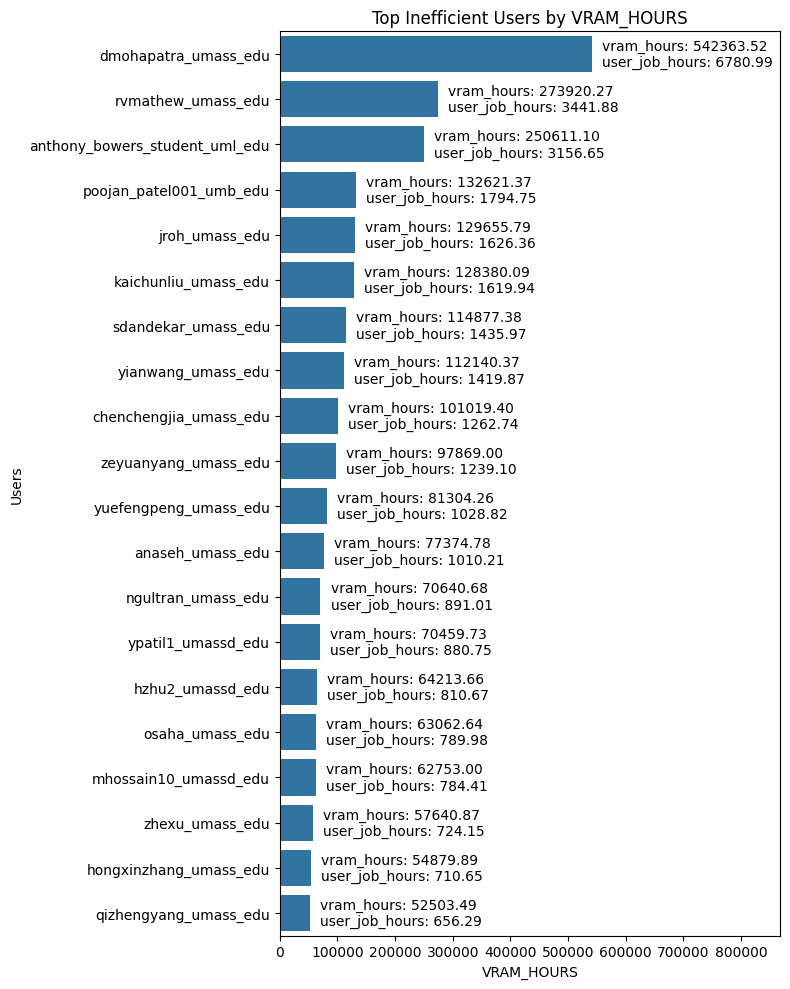

In [52]:
inefficient_users_vram_hours = efficiency_analysis.find_inefficient_users_by_vram_hours(
    vram_hours_filter={"min": 200, "inclusive": True},  # VRAM-hours threshold for identifying inefficient users
    min_jobs=5,  # Minimum number of jobs to consider a user
)
# Display top inefficient users by VRAM-hours
print("\nTop inefficient users by VRAM-hours:")
display(inefficient_users_vram_hours.head(20))


# Plot top inefficient users by VRAM-hours, with VRAM-hours as labels
users_with_metrics_visualizer = UsersWithMetricsVisualizer(inefficient_users_vram_hours.head(20))
users_with_metrics_visualizer.visualize(
    column="vram_hours", bar_label_columns=["vram_hours", "user_job_hours"], figsize=(8, 10)
)

In [53]:
efficiency_analysis.get_job_metrics_by_gpu_type()

,A100
Mean Used GPU Memory (GiB),15.719991
Median Used GPU Memory (GiB),1.166016
Mean Requested VRAM Efficiency,0.244513
Median Requested VRAM Efficiency,0.022241
Mean Allocated VRAM Efficiency,0.198604
Median Allocated VRAM Efficiency,0.014624
Total GPU Hours,459136.873056
Mean Weighted VRAM Efficiency,0.302870
Median Weighted VRAM Efficiency,0.010835
